# Customer Churn Prediction

## `Telco_Customer_Churn`

**Content**

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

Customers who left within the last month – the column is called Churn
Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
Demographic info about customers – gender, age range, and if they have partners and dependents

In [59]:
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [60]:
telco=pd.read_csv('../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
telco.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## EDA

In [61]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [62]:
telco.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [63]:
# Although,TotalCharges should be numerical data type,but it is object type here.
telco.TotalCharges=pd.to_numeric(telco.TotalCharges,errors='coerce') #If 'coerce', then invalid parsing will be set as NaN.

In [64]:
def null_values(telco):
    nv=pd.concat([telco.isnull().sum(), 100 * telco.isnull().sum()/telco.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv.Missing_Records>0].sort_values('Missing_Records', ascending=False)

In [65]:
null_values(telco)

,Missing_Records,Percentage (%)
TotalCharges,11,0.156183


In [66]:
telco.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [67]:
null_indexes=telco[telco.TotalCharges.isnull()].index
telco.loc[null_indexes,['tenure','MonthlyCharges','TotalCharges','Churn']]

,tenure,MonthlyCharges,TotalCharges,Churn
488,0,52.55,NaN,No
753,0,20.25,NaN,No
936,0,80.85,NaN,No
1082,0,25.75,NaN,No
1340,0,56.05,NaN,No
3331,0,19.85,NaN,No
3826,0,25.35,NaN,No
4380,0,20.00,NaN,No
5218,0,19.70,NaN,No
6670,0,73.35,NaN,No


In [68]:
# we can drop null values and customerID column.
telco=telco.fillna(0)
telco=telco.drop(['customerID'],axis=1)

In [69]:
telco['Churn_Rate']=telco['Churn'].map({"No":0,"Yes":1})

In [70]:
telco.rename(columns={"tenure": "Tenure", "gender": "Gender"},inplace=True)

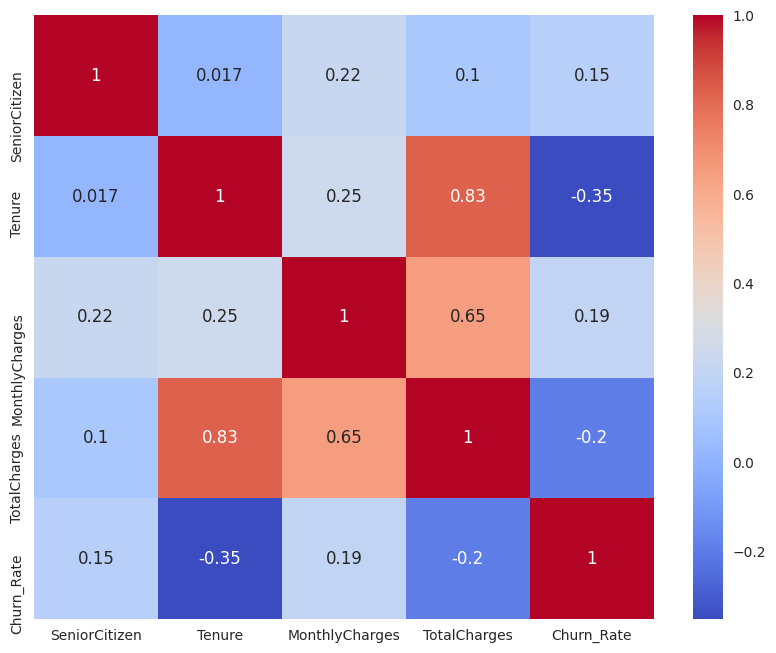

In [71]:
plt.figure(figsize=(10,8))
sns.heatmap(telco.corr(), cmap='coolwarm',annot=True);

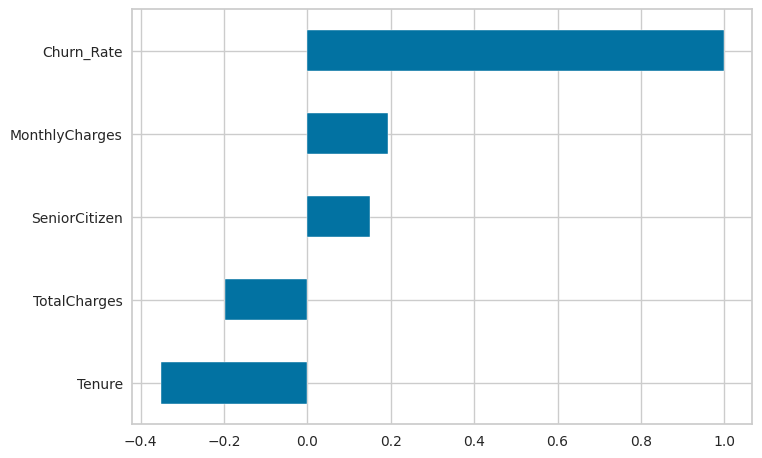

In [72]:
telco.corr()["Churn_Rate"].sort_values().plot.barh();

In [73]:
telco.describe()

,SeniorCitizen,Tenure,MonthlyCharges,TotalCharges,Churn_Rate
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304,0.265370
std,0.368612,24.559481,30.090047,2266.794470,0.441561
min,0.000000,0.000000,18.250000,0.000000,0.000000
25%,0.000000,9.000000,35.500000,398.550000,0.000000
50%,0.000000,29.000000,70.350000,1394.550000,0.000000
75%,0.000000,55.000000,89.850000,3786.600000,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000


In [74]:
# categorik verilerin istatistiksel analizi icin:
telco.describe(include=['O'])

,Gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


In [75]:
# her columns in num of uniques
telco.apply(lambda x: x.nunique())

Gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
Tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
Churn_Rate             2
dtype: int64

**Exploring the Data**

Our purpose here, mostly, understanding which and how variables are related to 'Churn'. Who wants to leave the telecom service company and why? So we made it 'Churn' oriented.

Customer churn is the loss of clients or customers.

In [76]:
print('Unique Values of Each Features:\n')
for i in telco:
    print(f'{i}:\n{sorted(telco[i].unique())}\n')

Unique Values of Each Features:

Gender:
['Female', 'Male']

SeniorCitizen:
[0, 1]

Partner:
['No', 'Yes']

Dependents:
['No', 'Yes']

Tenure:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]

PhoneService:
['No', 'Yes']

MultipleLines:
['No', 'No phone service', 'Yes']

InternetService:
['DSL', 'Fiber optic', 'No']

OnlineSecurity:
['No', 'No internet service', 'Yes']

OnlineBackup:
['No', 'No internet service', 'Yes']

DeviceProtection:
['No', 'No internet service', 'Yes']

TechSupport:
['No', 'No internet service', 'Yes']

StreamingTV:
['No', 'No internet service', 'Yes']

StreamingMovies:
['No', 'No internet service', 'Yes']

Contract:
['Month-to-month', 'One year', 'Two year']

PaperlessBilling:
['No', 'Yes']

PaymentMethod:
['Bank transfer (automatic

In [77]:
telco.Churn.value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [78]:
def perc_col(df,col):
    for i in sorted(df[col].unique(),reverse=True):
        print('%s: %%%.2f' % (i, 100*df[col].value_counts()[i]/len(df)))

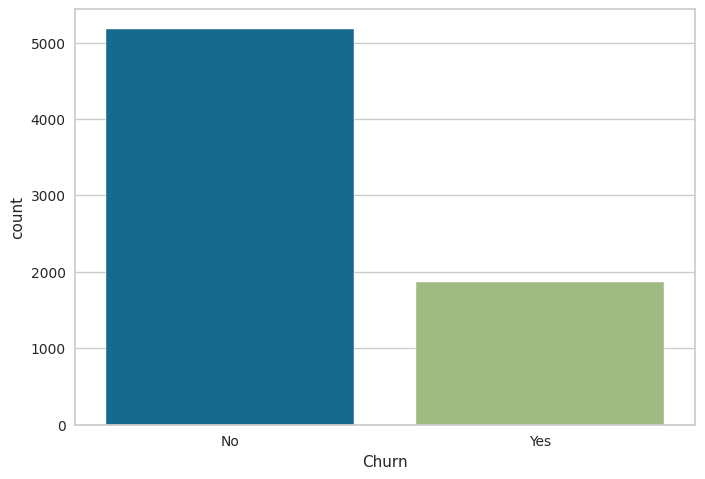

{'No': 5174, 'Yes': 1869}

Customer Attrition Ratio:
Yes: %26.54
No: %73.46


In [79]:
sns.countplot(x='Churn',data=telco)
plt.show()

print(dict(Counter(telco['Churn'])))
print('\nCustomer Attrition Ratio:')
perc_col(telco,'Churn')

### Gender - Partner 

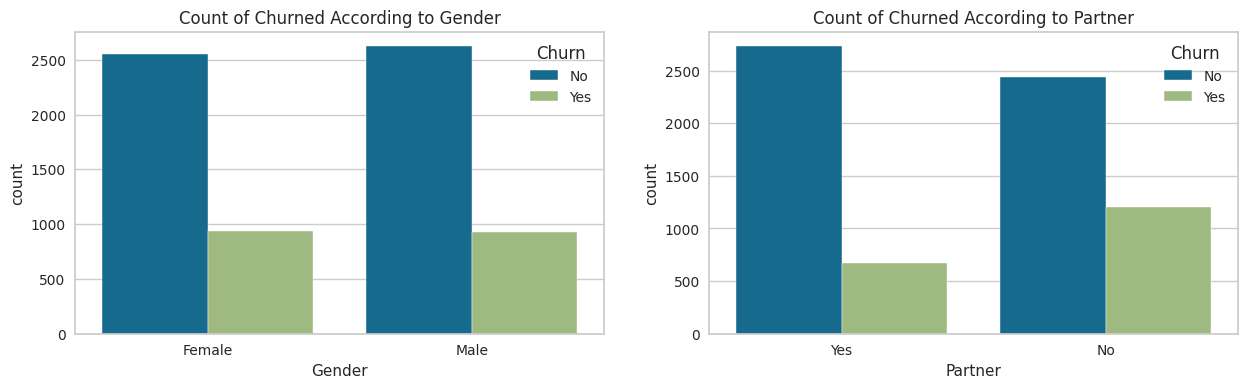

Churn:'Yes'
Gender: {'Male': 930, 'Female': 939}
Partner: {'No': 1200, 'Yes': 669}

Churn:'No'
Gender: {'Female': 2549, 'Male': 2625}
Partner: {'Yes': 2733, 'No': 2441}


In [80]:
plt.figure(figsize=(15,4))
plt.subplot(121)
plt.title("Count of Churned According to Gender")
sns.countplot(x='Gender', data=telco, hue='Churn')
plt.subplot(122)
plt.title("Count of Churned According to Partner")
sns.countplot(x='Partner', data=telco, hue='Churn')
plt.show()

print("Churn:'Yes'\n",
      'Gender: ',dict(Counter(telco[telco.Churn=='Yes']['Gender'])),
      '\nPartner: ',dict(Counter(telco[telco.Churn=='Yes']['Partner'])),
     "\n\nChurn:'No'\n",
      'Gender: ',dict(Counter(telco[telco.Churn=='No']['Gender'])),
     '\nPartner: ',dict(Counter(telco[telco.Churn=='No']['Partner'])),sep='')

> **`Gender` is ineffective for prediction of customer churn.**

### Phone Service - Streaming TV - MultipleLines

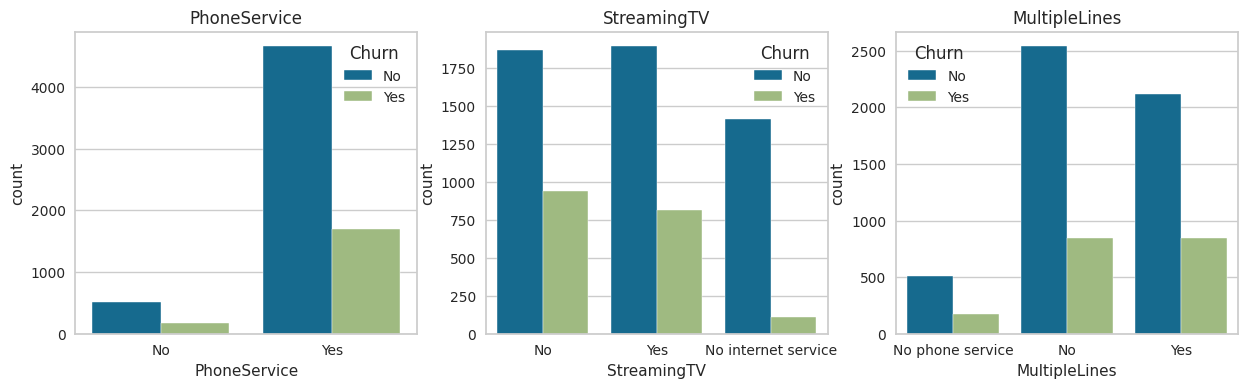

In [81]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.title("PhoneService")
sns.countplot(x='PhoneService',hue='Churn',data=telco)
plt.subplot(132)
plt.title("StreamingTV")
sns.countplot(x='StreamingTV',hue='Churn',data=telco)
plt.subplot(133)
plt.title("MultipleLines")
sns.countplot(x='MultipleLines',hue='Churn',data=telco)
plt.show()

> **Whether customer have `Phone Service` not does not seem to have an effect on the churn.**

### Online Security - Tech Support

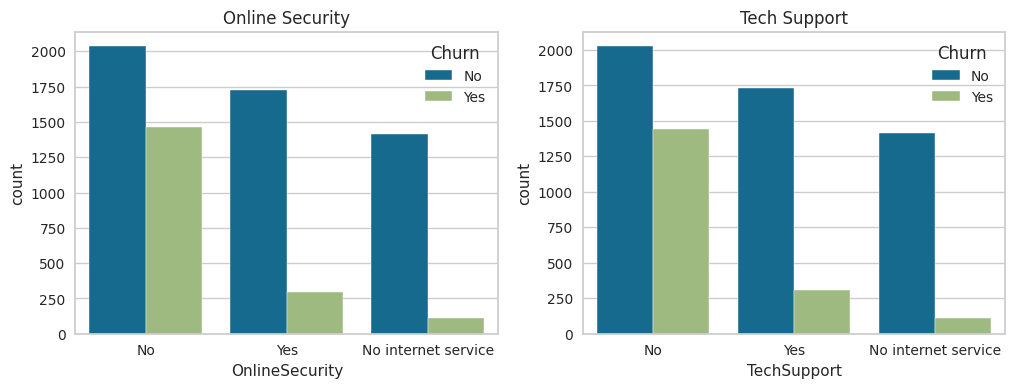

Churn Ratios by Online Security 

No                     41.77
Yes                    14.61
No internet service     7.40
Name: OnlineSecurity, dtype: float64

Churn Ratios by Tech Support 

No                     41.64
Yes                    15.17
No internet service     7.40
Name: TechSupport, dtype: float64


In [82]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title("Online Security")
sns.countplot(x = 'OnlineSecurity', hue = 'Churn', data = telco)
plt.subplot(122)
plt.title("Tech Support")
sns.countplot(x = 'TechSupport', hue = 'Churn', data = telco)
plt.show()

print('Churn Ratios by Online Security','\n')
print(round(telco[telco['Churn']=='Yes']['OnlineSecurity'].value_counts() / telco['OnlineSecurity'].value_counts()*100,2))

print('\nChurn Ratios by Tech Support','\n')
print(round(telco[telco['Churn']=='Yes']['TechSupport'].value_counts() / telco['TechSupport'].value_counts()*100,2))

> **Customers who did not sign up for `OnlineSecurity` and `TechSupport` are most likely to churn.**

### Tenure

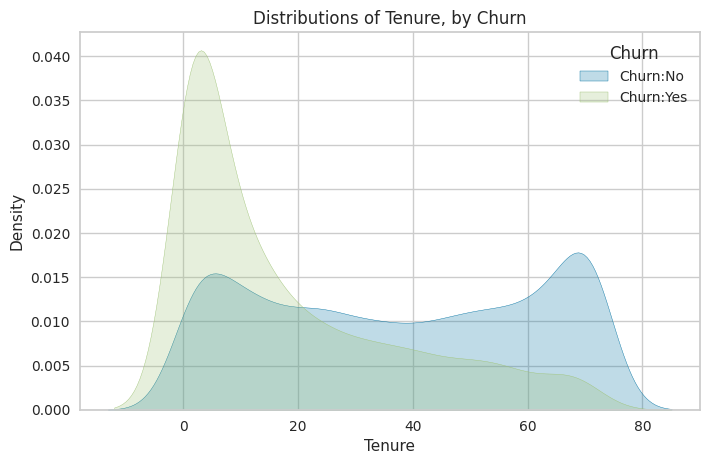

Average Tenure of Churned Customers: 18 
Average Tenure of Not-Churned Customers: 38


In [83]:
churn_tenure=telco[telco.Churn=='Yes']['Tenure']
not_churn_tenure=telco[telco.Churn=='No']['Tenure']

plt.figure(figsize=(8,5))
sns.kdeplot(data=not_churn_tenure, shade=True)
sns.kdeplot(data=churn_tenure, shade=True)
plt.legend(("Churn:No", "Churn:Yes"),title='Churn')
plt.title("Distributions of Tenure, by Churn")

plt.show()

print('Average Tenure of Churned Customers:',round(churn_tenure.mean()),
      '\nAverage Tenure of Not-Churned Customers:',round(not_churn_tenure.mean()))

> **Not churned customers have a much longer average tenure (20 months) than the churned customers.**

### Monthly Charges

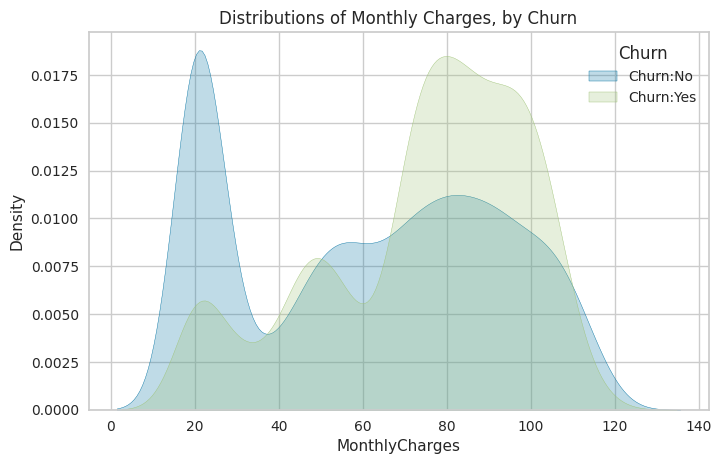

Average Monthly Fee of Churned Customers: 74 
Average Monthly Fee of Not-Churned Customers: 61


In [84]:
churn_mcharge=telco[telco.Churn=='Yes']['MonthlyCharges']
not_churn_mcharge=telco[telco.Churn=='No']['MonthlyCharges']
plt.figure(figsize=(8,5))

sns.kdeplot(data=not_churn_mcharge,shade=True)
sns.kdeplot(data=churn_mcharge,shade=True)
plt.legend(("Churn:No", "Churn:Yes"),title='Churn')
plt.title("Distributions of Monthly Charges, by Churn")
plt.show()

print('Average Monthly Fee of Churned Customers:',round(churn_mcharge.mean()),
      '\nAverage Monthly Fee of Not-Churned Customers:',round(not_churn_mcharge.mean()))

> **Churned customers paid over 20% higher on average monthly fee than not-churned customers.**

### Deal with Outliers

In [85]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   Tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [86]:
categorical=telco.select_dtypes(include='object').columns.tolist()
numeric=telco.dtypes[telco.dtypes!=object].keys().tolist() # result of dtypes is Series, so we use keys(), not columns
print('Categorical Features:',categorical,'\nNumerical Features:',numeric,sep='\n')

Categorical Features:
['Gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

Numerical Features:
['SeniorCitizen', 'Tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_Rate']


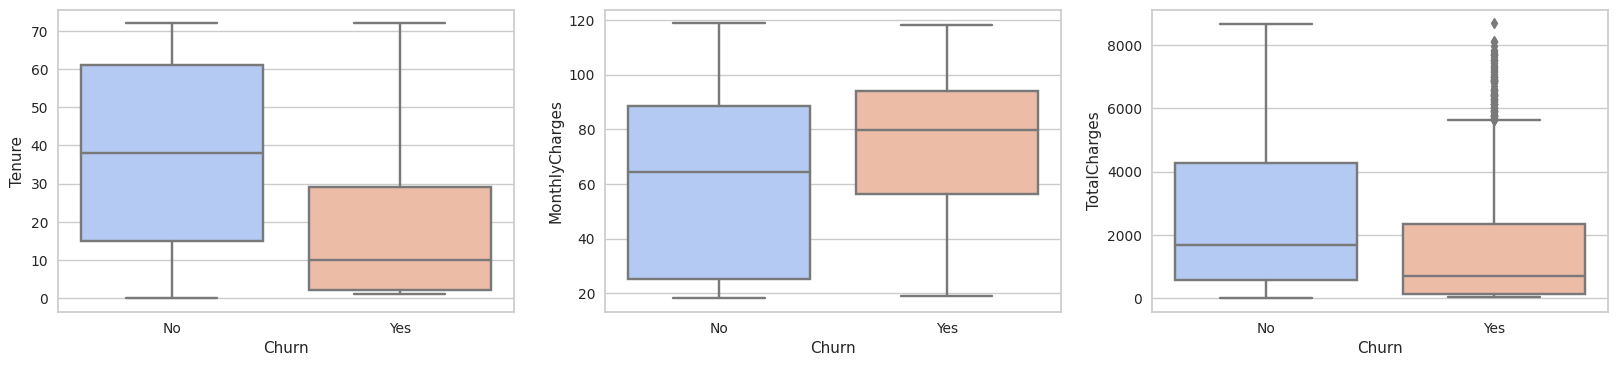

In [87]:
plt.figure(figsize=(20,4))
plt.subplot(131)
sns.boxplot(x='Churn', y='Tenure', data=telco, palette="coolwarm",whis=1.6)
plt.subplot(132)
sns.boxplot(x='Churn', y='MonthlyCharges', data=telco, palette="coolwarm")
plt.subplot(133)
sns.boxplot(x='Churn', y='TotalCharges', data=telco, palette="coolwarm")
plt.show()

**'TotalCharges' has some outliers. We can use root square for outliers.**

In [88]:
f=lambda x:(np.sqrt(x) if x>=0 else -np.sqrt(-x))
telco.TotalCharges=telco.TotalCharges.apply(f)

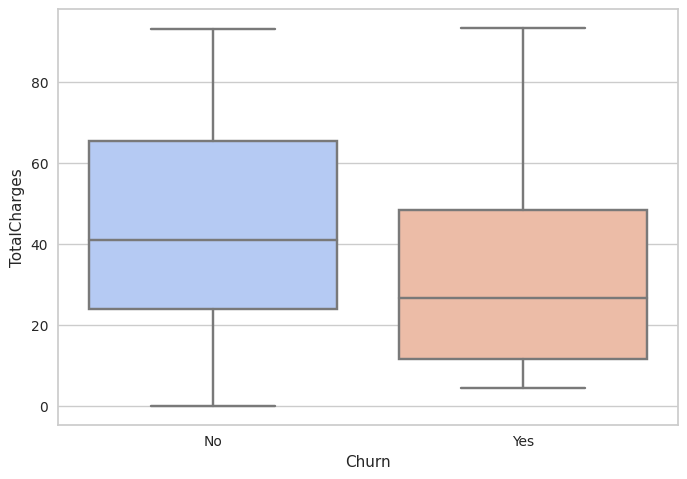

In [89]:
sns.boxplot(x='Churn', y='TotalCharges', data=telco, palette="coolwarm");

### Senior Citizen-Tenure-Monthly Charges

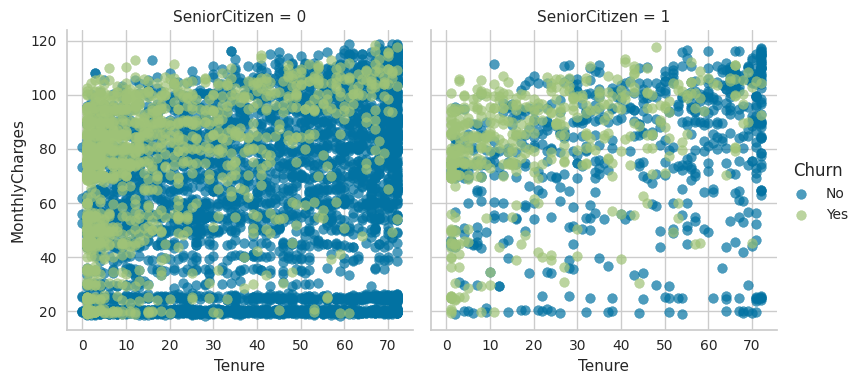

In [90]:
g=sns.FacetGrid(telco,col='SeniorCitizen', hue='Churn',height=4)
g.map(plt.scatter, 'Tenure', 'MonthlyCharges', alpha=0.7)
g.add_legend();

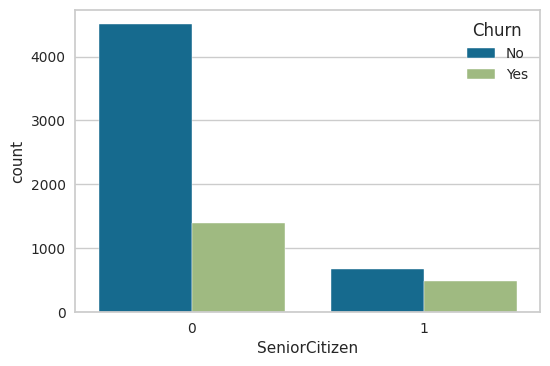

SeniorCitizens percentage of customers: % 16.21
SeniorCitizens churn rate: % 41.68
non-SeniorCitizens churn rate: % 23.61


In [91]:
plt.figure(figsize=(6,4))
sns.countplot(x='SeniorCitizen', data=telco, hue='Churn')
plt.show()

print('SeniorCitizens percentage of customers: % {:.2f}'.format(len(telco[telco.SeniorCitizen==1])/len(telco.SeniorCitizen)*100))
print('SeniorCitizens churn rate: % {:.2f}'.format(len(telco[(telco.SeniorCitizen==1) & (telco.Churn=='Yes')])/len(telco[telco.SeniorCitizen==1])*100))
print('non-SeniorCitizens churn rate: % {:.2f}'.format(len(telco[(telco.SeniorCitizen==0) & (telco.Churn=='Yes')])/len(telco[telco.SeniorCitizen==0])*100))

> **SeniorCitizens are only 16% of customers, but they have a much higher churn rate: 42% against 23% for non-senior customers.**

### Contract-Internet Service-Churn

In [92]:
telco.Contract.value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64

In [93]:
telco.InternetService.value_counts()

Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64

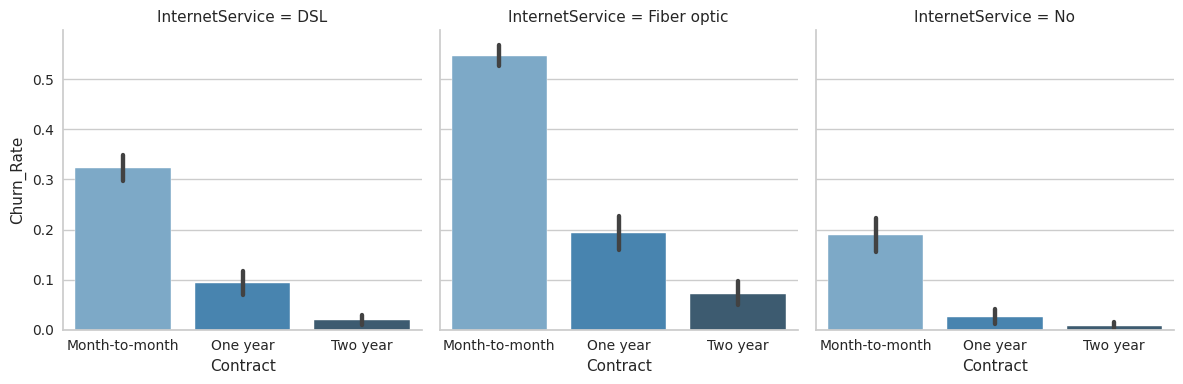

In [94]:
g = sns.FacetGrid(telco,col='InternetService',height=4)
ax = g.map(sns.barplot, "Contract", "Churn_Rate", palette = "Blues_d", order= telco.Contract.unique())

> **Short term contracts have higher churn rates. It is obvious that contract term does have an effect on churn.There were very few churns when customers have a two-year contract. And most churns occurred on customers with a month-to-month contract.**

> **It seems customers who signed up for Fiber optic are most likely to churn.**

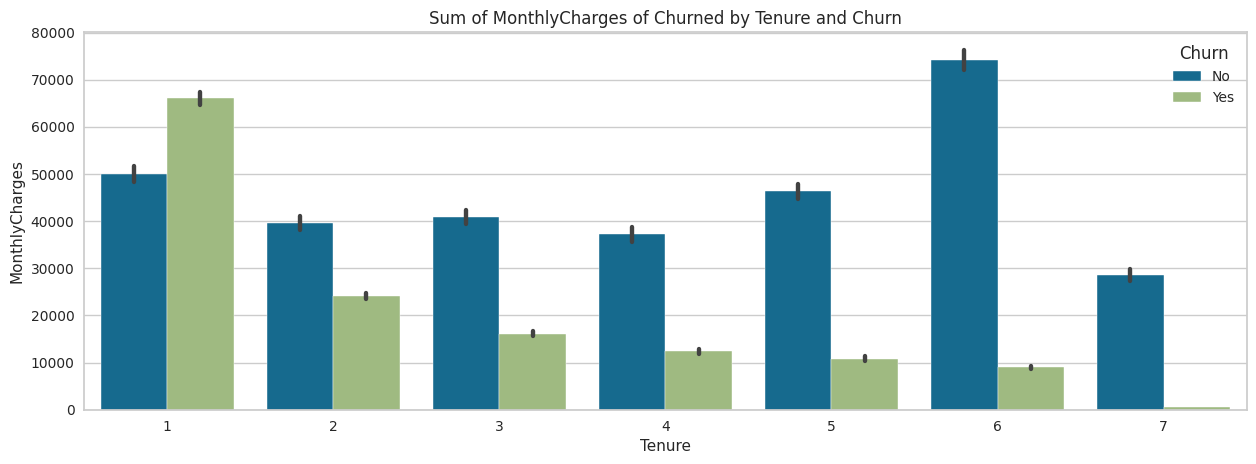

In [95]:
plt.figure(figsize=(15,5))
sns.barplot(x=telco.Tenure//12+1,y='MonthlyCharges',data=telco,hue='Churn',estimator=np.sum) #tenure with year
plt.title("Sum of MonthlyCharges of Churned by Tenure and Churn")
plt.show()

In [96]:
print('Average MonthlyCharges of Churned by Tenure:',
      telco.groupby([telco.Tenure//12+1,'Churn']).MonthlyCharges.mean(),sep='\n\n')

Average MonthlyCharges of Churned by Tenure:

Tenure  Churn
1       No       46.689346
        Yes      66.088388
2       No       53.617751
        Yes      78.134304
3       No       59.867862
        Yes      83.742228
4       No       61.913372
        Yes      85.056507
5       No       66.560402
        Yes      87.725203
6       No       72.250389
        Yes      96.915054
7       No       80.423174
        Yes      96.875000
Name: MonthlyCharges, dtype: float64


In [97]:
print('Sum of Churned Count by Tenure:',
      telco.groupby([telco.Tenure//12+1,'Churn']).MonthlyCharges.count(),sep='\n\n')

Sum of Churned Count by Tenure:

Tenure  Churn
1       No       1070
        Yes       999
2       No        738
        Yes       309
3       No        683
        Yes       193
4       No        602
        Yes       146
5       No        697
        Yes       123
6       No       1028
        Yes        93
7       No        356
        Yes         6
Name: MonthlyCharges, dtype: int64


> **In first year, count of the Churned and Not Churned are close to each other. In the later years,the Not Churned customers are more than Churned customers.**

### Transform to Dummy and Drop Categorical Features

In [98]:
telco.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_Rate
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,5.463515,No,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,No,One year,No,Mailed check,56.95,43.468379,No,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,10.399519,Yes,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,42.903963,No,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,12.314625,Yes,1


In [99]:
telco['Churn']=telco['Churn'].map({"No":0,"Yes":1})
telco.drop(columns=['Churn_Rate'],axis=1,inplace=True)

In [100]:
import pickle
pickle.dump(telco,open("telco_not_dummy.pkl","wb"))

In [101]:
telco=pd.get_dummies(telco,drop_first=True)
telco.head()

,SeniorCitizen,Tenure,MonthlyCharges,TotalCharges,Churn,Gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,5.463515,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,1,0
1,0,34,56.95,43.468379,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,0,2,53.85,10.399519,1,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
3,0,45,42.30,42.903963,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,2,70.70,12.314625,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0


In [102]:
telco.isnull().sum().any()

False

In [103]:
telco.to_csv("./telco_clean_20201215.csv", index = False)

## Customer Churn Prediction

In [104]:
# conda install -c districtdatalabs yellowbrick

In [105]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from IPython.core.pylabtools import figsize
from scipy.stats import zscore
from scipy import stats
from sklearn.metrics import accuracy_score,f1_score, recall_score, classification_report,confusion_matrix,precision_score,roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from statsmodels.formula.api import ols
from scipy.stats import zscore
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from xgboost import XGBClassifier
from yellowbrick.classifier import ClassificationReport
from yellowbrick.datasets import load_occupancy
font_title = {'family': 'times new roman', 'color': 'darkred', 
              'weight': 'bold', 'size': 14}
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = 100

### Building Models

In [106]:
df = pd.read_csv("./telco_clean_20201215.csv")
df.head()

,SeniorCitizen,Tenure,MonthlyCharges,TotalCharges,Churn,Gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,5.463515,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,1,0
1,0,34,56.95,43.468379,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,0,2,53.85,10.399519,1,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
3,0,45,42.30,42.903963,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,2,70.70,12.314625,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0


In [107]:
df.Churn.value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

In [108]:
print("Percentage of Churned Customer:%",
      round(df.Churn.mean(),2))

Percentage of Churned Customer:% 0.27


> **Target variable is a bit of imbalanced. We should resample the data.**

## Splitting Data

In [109]:
X=df.drop('Churn',axis=1)
y=df.Churn

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42) # stratify=y

In [111]:
y_train.value_counts()

0    4138
1    1496
Name: Churn, dtype: int64

### SMOTE

In [112]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X_train, y_train) # fit_sample
y_smote.value_counts()

0    4138
1    4138
Name: Churn, dtype: int64

### ADASYN

In [113]:
ad = ADASYN(random_state=42)
X_adasyn, y_adasyn = ad.fit_resample(X_train, y_train)  # fit_sample
y_adasyn.value_counts()

1    4183
0    4138
Name: Churn, dtype: int64

In [114]:
# SMOTE
X_train, y_train = X_smote, y_smote

# ADASYN
# X_train, y_train = X_adasyn, y_adasyn

In [119]:
# pip install lazypredict==0.2.9
# import lazypredict
# from lazypredict.Supervised import LazyClassifier
# from sklearn.utils.testing import ignore_warnings

# clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
# models, predictions = clf.fit (X_train, X_test, y_train, y_test)
# models

# ``1.XGBoost Classifer``

In [120]:
from xgboost import XGBClassifier
xgb= XGBClassifier()
xgb.fit(X_train , y_train)

[06:48:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [121]:
y_pred = xgb.predict(X_test)

### **Evaluate the performance**

In [122]:
print('Confusion Matrix:',*confusion_matrix(y_test,y_pred), sep="\n")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[868 168]
[144 229]
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1036
           1       0.58      0.61      0.59       373

    accuracy                           0.78      1409
   macro avg       0.72      0.73      0.72      1409
weighted avg       0.78      0.78      0.78      1409



In [123]:
xgb_accuracy = accuracy_score(y_test, y_pred)
xgb_f1_score = f1_score(y_test, y_pred, average='weighted')
xgb_recall = recall_score(y_test, y_pred, average='weighted')
print('xgb_accuracy:',xgb_accuracy,
      '\nxgb_f1_score:',xgb_f1_score,
      '\nxgb_recall:',xgb_recall)

xgb_accuracy: 0.7785663591199432 
xgb_f1_score: 0.7807198102642567 
xgb_recall: 0.7785663591199432


### **Tunning XGBOOST**

In [124]:
xgb = XGBClassifier()

In [125]:
xgb_params = {"n_estimators": [50,500,1000],
             "subsample":[0.1,0.5,1],
             "max_depth":[3,7,9],
             "learning_rate":[0.1,0.01,0.3]}

In [126]:
# xgb_grid= GridSearchCV(xgb, xgb_params, cv = 5, 
#                             n_jobs = -1, verbose = 2).fit(X_train, y_train)

In [127]:
# xgb_grid= RandomizedSearchCV(xgb, xgb_params, cv = 5,
#                              n_iter=10,
#                             n_jobs = -1, verbose = 2,scoring='f1').fit(X_train, y_train)

In [128]:
# xgb_grid.best_params_

In [129]:
xgb_tuned = XGBClassifier(learning_rate= 0.01, 
                                max_depth= 3, 
                                n_estimators= 520, 
                                subsample= 0.15).fit(X_train, y_train)

y_pred = xgb_tuned.predict(X_test)

[06:48:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [130]:
print('Confusion Matrix:',*confusion_matrix(y_test,y_pred), sep="\n")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[801 235]
[ 81 292]
              precision    recall  f1-score   support

           0       0.91      0.77      0.84      1036
           1       0.55      0.78      0.65       373

    accuracy                           0.78      1409
   macro avg       0.73      0.78      0.74      1409
weighted avg       0.81      0.78      0.79      1409



In [131]:
xgb_f1_true=float(classification_report(y_test, y_pred).split()[12])
xgb_f1_true

0.65

In [132]:
xgb_accuracy = accuracy_score(y_test, y_pred)
xgb_f1_score = f1_score(y_test, y_pred, average='weighted')
xgb_recall = recall_score(y_test, y_pred, average='weighted')
print('xgb_accuracy:',xgb_accuracy,
      '\nxgb_f1_score:',xgb_f1_score,
      '\nxgb_recall:',xgb_recall)

xgb_accuracy: 0.7757274662881476 
xgb_f1_score: 0.7859115856413728 
xgb_recall: 0.7757274662881476


**`Cross Validation Scores`**

In [133]:
# xgb_accuracy = cross_val_score(xgb_tuned, X_test, y_test,cv = 10).mean()
# xgb_f1_score = cross_val_score(xgb_tuned, X_test, y_test,cv = 10,scoring='f1_weighted').mean()
# xgb_recall = cross_val_score(xgb_tuned, X_test, y_test,cv = 10,scoring='recall_weighted').mean()
# print('rfc_accuracy:',rfc_accuracy,
#       '\nrfc_f1_score:',rfc_f1_score,
#       '\nrfc_recall:',rfc_recall)

### Visualization of Confusion Matrix with Table

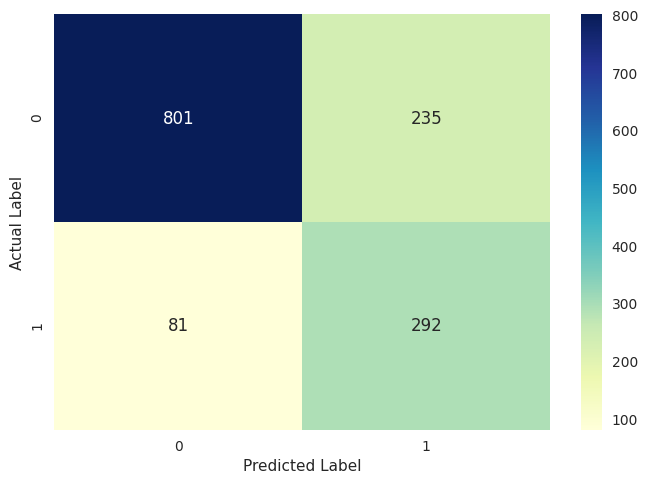

In [134]:
from sklearn.metrics import classification_report,confusion_matrix
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, cmap="YlGnBu",fmt='d')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label');

# ``2.Random Forest Classifier``

In [135]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [136]:
y_pred = rf_model.predict(X_test)

### **Evaluate the performance**

In [137]:
print('Confusion Matrix:',*confusion_matrix(y_test,y_pred), sep="\n")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[886 150]
[152 221]
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1036
           1       0.60      0.59      0.59       373

    accuracy                           0.79      1409
   macro avg       0.72      0.72      0.72      1409
weighted avg       0.79      0.79      0.79      1409



In [138]:
rfc_accuracy = accuracy_score(y_test, y_pred)
rfc_f1_score = f1_score(y_test, y_pred, average='weighted')
rfc_recall = recall_score(y_test, y_pred, average='weighted')
print('rfc_accuracy:',rfc_accuracy,
      '\nrfc_f1_score:',rfc_f1_score,
      '\nrfc_recall:',rfc_recall)

rfc_accuracy: 0.7856635911994322 
rfc_f1_score: 0.7854788490878661 
rfc_recall: 0.7856635911994322


**`Cross Validation Scores`**

In [139]:
# rfc_accuracy = cross_val_score(rf_model, X_test, y_test,cv = 10).mean()
# rfc_f1_score = cross_val_score(rf_model, X_test, y_test,cv = 10,scoring='f1_weighted').mean()
# rfc_recall = cross_val_score(rf_model, X_test, y_test,cv = 10,scoring='recall_weighted').mean()
# print('rfc_accuracy:',rfc_accuracy,
#       '\nrfc_f1_score:',rfc_f1_score,
#       '\nrfc_recall:',rfc_recall)

### **RF Tunning**

In [140]:
rfc_params = {"n_estimators":[300,500,1000],
              "max_depth":[7,10,15],
              "max_features": [8,10,15],
              "min_samples_split": [4,6,8]}

In [141]:
# rfc_grid = GridSearchCV(rf_model, rfc_params, cv = 5, n_jobs = -1, verbose = 2).fit(X_train, y_train)

In [142]:
# rfc_grid= RandomizedSearchCV(rf_model, xgb_params, cv = 5,
#                              n_iter=10,
#                             n_jobs = -1, verbose = 2,scoring='f1').fit(X_train_tf_idf, y_train)

In [143]:
# rfc_grid.best_params_

In [144]:
rfc_tuned = RandomForestClassifier(max_depth = 10,             
                                  max_features = 10, 
                                  min_samples_split = 4, 
                                  n_estimators = 500).fit(X_train, y_train)

In [145]:
y_pred = rfc_tuned.predict(X_test)
print('Confusion Matrix:',*confusion_matrix(y_test,y_pred), sep="\n")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[836 200]
[ 97 276]
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      1036
           1       0.58      0.74      0.65       373

    accuracy                           0.79      1409
   macro avg       0.74      0.77      0.75      1409
weighted avg       0.81      0.79      0.80      1409



In [146]:
rf_f1_true=float(classification_report(y_test, y_pred).split()[12])
rf_f1_true

0.65

### **Visualization of Confusion Matrix with Table**

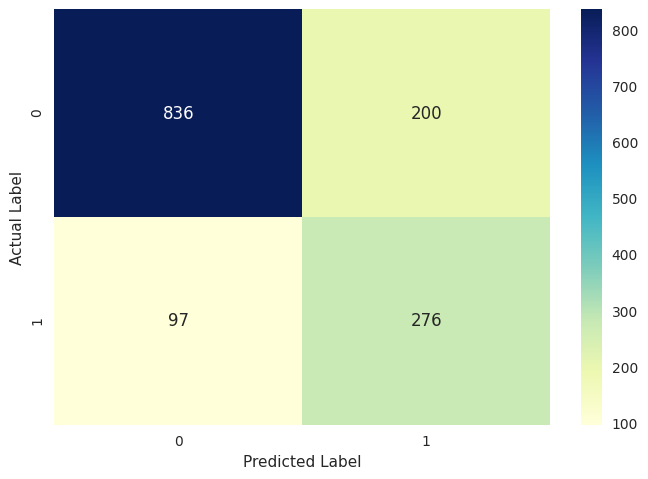

In [147]:
from sklearn.metrics import classification_report,confusion_matrix
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, cmap="YlGnBu",fmt='d')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label');

# ``3.KNeighborsClassifer``

### Scaling

In [148]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test= sc.transform(X_test)

In [149]:
from sklearn.neighbors import KNeighborsClassifier

In [150]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

In [151]:
y_pred = knn.predict(X_test)

### **Visualize Accuracies of Train & Test Data by Different k`s**

In [152]:
neighbors = range(1,18,2) # k nin tek sayi olmasi beklenir.
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors = k)
    
    #Fit the model
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test)

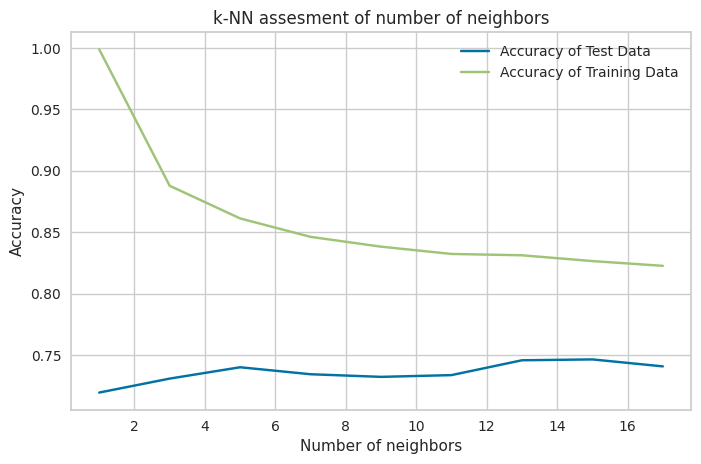

In [153]:
plt.figure(figsize=(8,5))
plt.title('k-NN assesment of number of neighbors')
plt.plot(neighbors, test_accuracy, label='Accuracy of Test Data')
plt.plot(neighbors, train_accuracy, label='Accuracy of Training Data')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

### **Find Optimum K Value with Elbow Method**

In [154]:
error_rate = []
# Her bir error rate icin olusan k degeri bu listeye atilacak
# k nin tek sayi olmasi beklenir.
# Will take some time
for i in range(1,18,2):
    
    model = KNeighborsClassifier(n_neighbors=i) # k= i
    model.fit(X_train,y_train)
    y_pred_i = model.predict(X_test)
    error_rate.append(np.mean(y_pred_i != y_test)) 
    

# print('Optimum K_Value: ',error_rate.index(min(error_rate)))

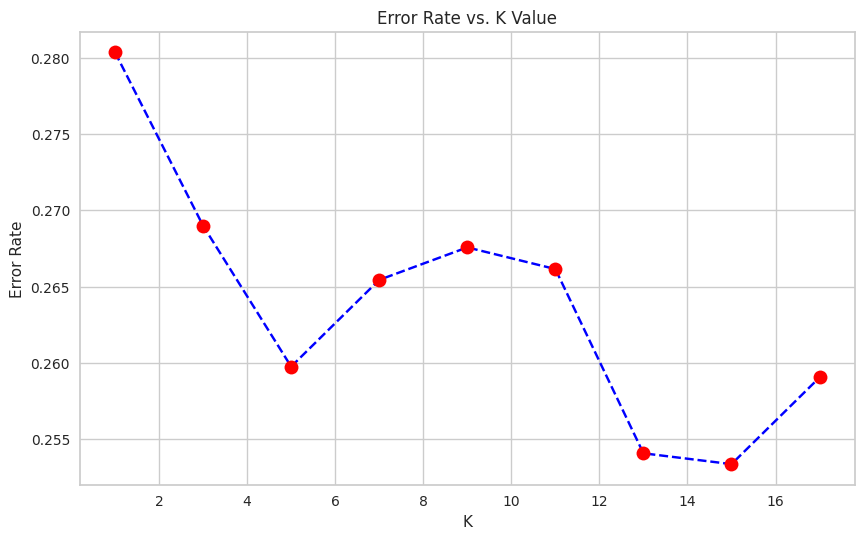

In [155]:
plt.figure(figsize=(10,6))
plt.plot(range(1,18,2),
         error_rate,
         color='blue', 
         linestyle='dashed', 
         marker='o',
         markerfacecolor='red', 
         markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate');

### Tunning KNN with GridSearchCV

In [156]:
knn = KNeighborsClassifier()
knn_params = {"n_neighbors": range(1,18,2)} # k tek sayi olmali

knn_cv_model = GridSearchCV(knn, knn_params, cv=10).fit(X_train, y_train)

In [157]:
knn_cv_model.best_params_

{'n_neighbors': 9}

In [158]:
knn_tuned= KNeighborsClassifier(n_neighbors = 33).fit(X_train, y_train)
y_pred = knn_tuned.predict(X_test)

### **Evaluate the Performance**

In [159]:
print('Confusion Matrix:',*confusion_matrix(y_test,y_pred), sep="\n")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[733 303]
[ 66 307]
              precision    recall  f1-score   support

           0       0.92      0.71      0.80      1036
           1       0.50      0.82      0.62       373

    accuracy                           0.74      1409
   macro avg       0.71      0.77      0.71      1409
weighted avg       0.81      0.74      0.75      1409



In [160]:
knn_accuracy = accuracy_score(y_test, y_pred)
knn_f1_score = f1_score(y_test, y_pred, average='weighted')
knn_recall = recall_score(y_test, y_pred, average='weighted')
print('knn_accuracy:',knn_accuracy,
      '\nknn_f1_score:',knn_f1_score,
      '\nknn_recall:',knn_recall)

knn_accuracy: 0.7381121362668559 
knn_f1_score: 0.7527704405171632 
knn_recall: 0.7381121362668559


In [161]:
knn_f1_true=float(classification_report(y_test, y_pred).split()[12])
knn_f1_true

0.62

### Visualization of Confusion Matrix with Table

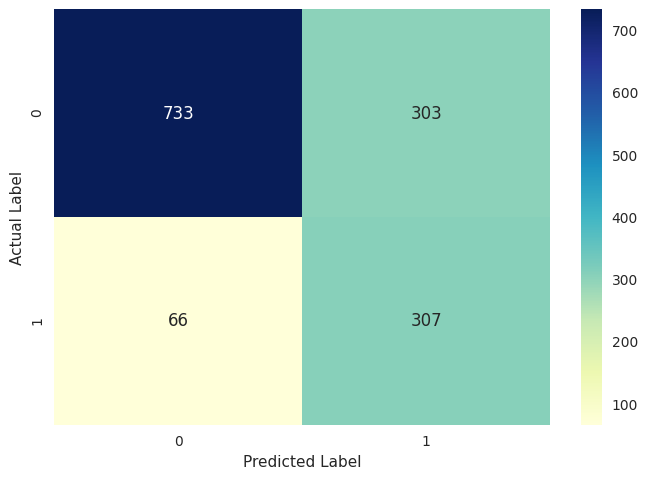

In [162]:
from sklearn.metrics import classification_report,confusion_matrix
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, cmap="YlGnBu",fmt='d')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label');

# `4-Logistic Regression`

In [163]:
model=LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression()

In [164]:
y_pred=model.predict(X_test)

### **Evaluate the performance**

In [165]:
print('Confusion Matrix:',*confusion_matrix(y_test,y_pred), sep="\n")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[852 184]
[114 259]
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1036
           1       0.58      0.69      0.63       373

    accuracy                           0.79      1409
   macro avg       0.73      0.76      0.74      1409
weighted avg       0.80      0.79      0.79      1409



In [166]:
log_accuracy = accuracy_score(y_test, y_pred)
log_f1_score = f1_score(y_test, y_pred, average='weighted')
log_recall = recall_score(y_test, y_pred, average='weighted')
print('log_accuracy:',log_accuracy,
      '\nlog_f1_score:',log_f1_score,
      '\nlog_recall:',log_recall)

log_accuracy: 0.7885024840312278 
log_f1_score: 0.7938765596418083 
log_recall: 0.7885024840312278


In [167]:
log_f1_true=float(classification_report(y_test, y_pred).split()[12])
log_f1_true

0.63

### `Compare Models Accuracies & F1 Scores & Recall`

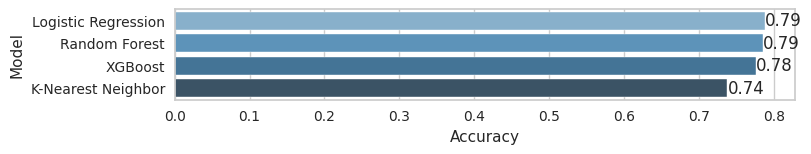

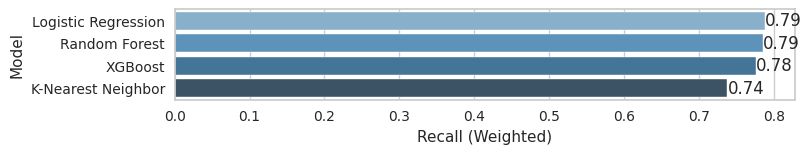

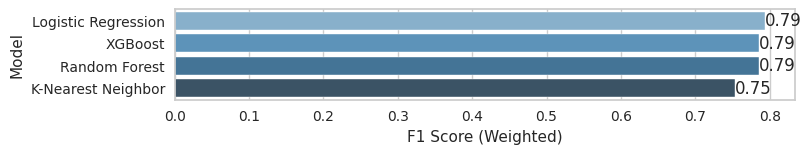

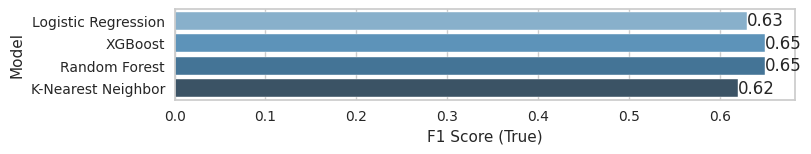

In [168]:
compare = pd.DataFrame({"Model": ["Random Forest", "XGBoost","Logistic Regression","K-Nearest Neighbor"],
                        "Accuracy": [rfc_accuracy, xgb_accuracy, log_accuracy,knn_accuracy],
                        "F1 Score": [rfc_f1_score, xgb_f1_score, log_f1_score, knn_f1_score],
                        "Recall": [rfc_recall, xgb_recall, log_recall,knn_recall],
                        "F1 Score (True)": [rf_f1_true, xgb_f1_true, log_f1_true, knn_f1_true]})

def labels(ax):
    for p in ax.patches:
        width = p.get_width()    # get bar length
        ax.text(width,       # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
                '{:1.2f}'.format(width), # set variable to display, 2 decimals
                ha = 'left',   # horizontal alignment
                va = 'center')  # vertical alignment
    
plt.subplot(411)
compare = compare.sort_values(by="Accuracy", ascending=False)
ax=sns.barplot(x="Accuracy", y="Model", data=compare, palette="Blues_d")
labels(ax)
plt.show()

plt.subplot(412)
compare = compare.sort_values(by="Recall", ascending=False)
ax=sns.barplot(x="Recall", y="Model", data=compare, palette="Blues_d")
labels(ax)
plt.xlabel('Recall (Weighted)')
plt.show()

plt.subplot(413)
compare = compare.sort_values(by="F1 Score", ascending=False)
ax=sns.barplot(x="F1 Score", y="Model", data=compare, palette="Blues_d")
labels(ax)
plt.xlabel('F1 Score (Weighted)')
plt.show()

plt.subplot(414)
compare = compare.sort_values(by="F1 Score", ascending=False)
ax=sns.barplot(x="F1 Score (True)", y="Model", data=compare, palette="Blues_d")
labels(ax)
plt.show()

### Result
* F1 score is used in the case where we have skewed classes i.e one type of class examples more than the other type class examples.
* For Churn Analysis, `F1 score of True Class` is the most important parameter.
* As we can say, XGBoost and Random Forest Classifier with SMOTE algorithm are the best models when we looked at the `F1 score of True Class`

### Feature Importance for XGBoost

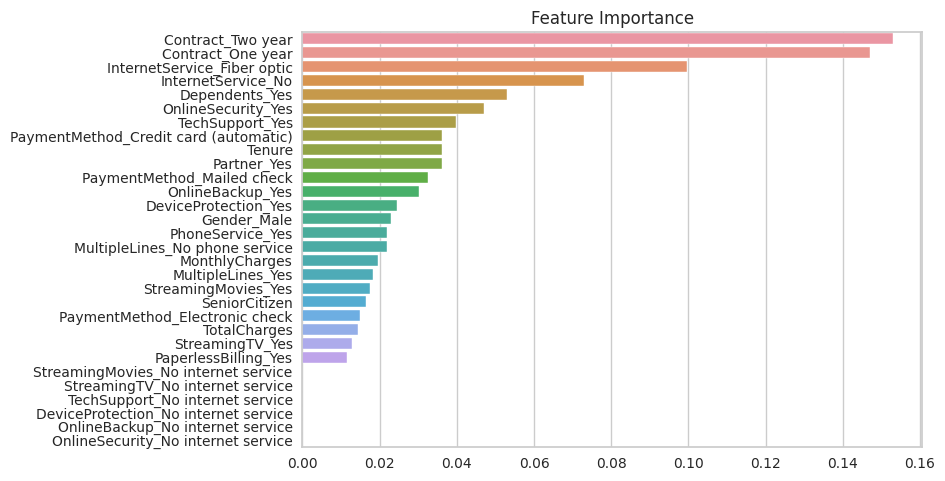

Contract_Two year                        0.152977
Contract_One year                        0.146938
InternetService_Fiber optic              0.099742
InternetService_No                       0.073014
Dependents_Yes                           0.052976
OnlineSecurity_Yes                       0.046905
TechSupport_Yes                          0.039812
PaymentMethod_Credit card (automatic)    0.036190
Tenure                                   0.036166
Partner_Yes                              0.036026
dtype: float32

In [169]:
feature_imp = pd.Series(xgb_tuned.feature_importances_,
                        index=X.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.title("Feature Importance")
plt.show()

feature_imp[:10]

### Feature Importance for Random Forest

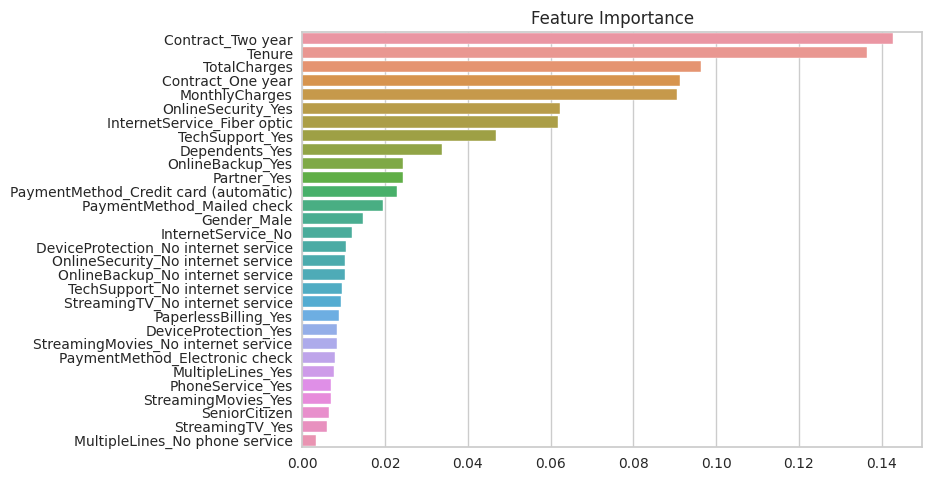

Contract_Two year              0.142744
Tenure                         0.136402
TotalCharges                   0.096395
Contract_One year              0.091312
MonthlyCharges                 0.090452
OnlineSecurity_Yes             0.062166
InternetService_Fiber optic    0.061798
TechSupport_Yes                0.046673
Dependents_Yes                 0.033821
OnlineBackup_Yes               0.024411
dtype: float64

In [170]:
feature_imp = pd.Series(rfc_tuned.feature_importances_,
                        index=X.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.title("Feature Importance")
plt.show()

feature_imp[:10]

   **Top 10 Feature Importance for XGBoost**
   
    Contract_Two year                        0.152446
    Contract_One year                        0.147547
    InternetService_Fiber optic              0.099390
    InternetService_No                       0.072385
    Dependents_Yes                           0.053979
    OnlineSecurity_Yes                       0.046085
    TechSupport_Yes                          0.039856
    PaymentMethod_Credit card (automatic)    0.036813
    Partner_Yes                              0.036286
    Tenure                                   0.036252

### Saving Model

In [171]:
import pickle
import pandas as pd

In [172]:
pickle.dump(xgb_tuned,open("XGBoost.pkl","wb"))
pickle.dump(rfc_tuned,open("RandomForest.pkl","wb"))

In [173]:
xgb_model = pickle.load(open("XGBoost.pkl","rb"))
rfc_model = pickle.load(open("RandomForest.pkl","rb"))
# df = pd.read_csv("telco_clean_20201215.csv")

In [174]:
new_list=["Contract", "InternetService", "Dependents", "OnlineSecurity",'TechSupport',"PaymentMethod",'Partner','Tenure']

In [175]:
my_dict = {"Contract":'Month-to-month', 
           "InternetService":'Fiber optic', 
           "Dependents":"Yes", 
           "OnlineSecurity":'Yes',
           "TechSupport":'Yes',
           'PaymentMethod':'Electronic check',
           'Partner':'Yes',
           'Tenure':60,
           'TotalCharges':2500
            }

X = pd.DataFrame.from_dict([my_dict])

X=pd.get_dummies(X)
X.columns

Index(['Tenure', 'TotalCharges', 'Contract_Month-to-month',
       'InternetService_Fiber optic', 'Dependents_Yes', 'OnlineSecurity_Yes',
       'TechSupport_Yes', 'PaymentMethod_Electronic check', 'Partner_Yes'],
      dtype='object')

In [176]:
all_columns=df.drop('Churn',axis=1).columns
all_columns

Index(['SeniorCitizen', 'Tenure', 'MonthlyCharges', 'TotalCharges',
       'Gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [177]:
X = pd.get_dummies(X).reindex(columns=all_columns, fill_value=0)
X

,SeniorCitizen,Tenure,MonthlyCharges,TotalCharges,Gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,60,0,2500,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [178]:
prediction_XGB = xgb_model.predict(X)
print("The Churn : ",'Yes' if prediction_XGB[0] else 'No')

The Churn :  No


In [179]:
prediction_XGB = xgb_model.predict_proba(X)
print(f'The Probability of the Customer Churn is %{round(prediction_XGB[0][1]*100,1)}')

The Probability of the Customer Churn is %18.4


In [184]:
# pip freeze -o requirements.txt